<a href="https://colab.research.google.com/github/michalinahulak/Fake_News_Detection/blob/main/1_WELFake_Fake_News.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ydata-profiling

In [ ]:
!pip install --upgrade gensim

In [ ]:
!pip install sentence-transformers

In [ ]:
!pip install optuna

# Imports

In [1]:
import pandas as pd

import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from ydata_profiling import ProfileReport

from wordcloud import WordCloud, STOPWORDS
import string
from string import punctuation

import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize

import gensim
from gensim.models import Word2Vec

from sentence_transformers import SentenceTransformer

from sklearn.utils import resample
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_distances

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import optuna

In [5]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
!ls -la '/content/drive/My Drive/Colab Notebooks/Codecool/Fake News Classification'

total 2046041
-rw------- 1 root root    3218751 May  2 21:00  1.WELFake_Fake_News.ipynb
-rw------- 1 root root    3926599 May  2 20:45  2.FakeandReal.ipynb
-rw------- 1 root root    3069257 Apr 29 19:49 '3. FakeNewsnet.ipynb'
-rw------- 1 root root 1587898029 Apr 26 22:10  dane_sentencetransformer.csv
-rw------- 1 root root  237145983 Apr 27 09:01  df_downsampled_welfake.csv
-rw------- 1 root root     763760 Apr 22 08:14  fakeandreal_pandasprofiling.html
-rw------- 1 root root   42975911 Apr 12 13:19  fakeandreal.zip
-rw------- 1 root root   62789876 May  2 18:39  Fake.csv
-rw------- 1 root root      36424 Apr 20 19:17  fake_fact.jpg
-rw------- 1 root root     674130 Apr 25 18:53  fakenews_pandasprofiling.html
-rw------- 1 root root    1760511 Apr 12 13:19  fakenews.zip
-rw------- 1 root root       3605 Apr 25 19:32  functions.py
-rw------- 1 root root      36152 Apr 25 12:53  modeling_algorithm.png
-rw------- 1 root root      12558 Apr 25 19:15  modeling_scripts.py
drwx------ 2 root r

In [4]:
%cd /content/drive/My Drive/Colab Notebooks/Codecool/Fake News Classification

/content/drive/My Drive/Colab Notebooks/Codecool/Fake News Classification


In [9]:
import functions
from functions import generate_word_cloud, remove_stopwords_and_punctuation, tokenize, stem_tokens, create_bow_df, create_b2v_df, split_data

In [10]:
import modeling_scripts
from modeling_scripts import create_logistic_regression, perform_kfold_cross_validation, create_more_complex_nn

# Loading dataset

In [5]:
df = pd.read_csv('WELFake_Dataset.csv.zip', compression='zip', index_col=0)

In [ ]:
df.head()

,title,text,label
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,NaN,Did they post their votes for Hillary already?,1
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


# Basic info

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72134 entries, 0 to 72133
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   71576 non-null  object
 1   text    72095 non-null  object
 2   label   72134 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.2+ MB


In [ ]:
description = "Disclaimer: this profiling report was generated using a sample of 15% of the original dataset."
sample = df.sample(frac=0.15)

In [ ]:
profile = sample.profile_report(dataset={"description": description})
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
profile.to_file("WELFake_Fake_News_pandasprofiling.html")

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

# Preprocessing

In [ ]:
# check missing value

df.isnull().sum().sort_values(ascending = False)

title    558
text      39
label      0
dtype: int64

Note: Missing data is less than 1% of the total dataset, therefore rows containing missing data will be removed.

In [6]:
df = df\
.dropna()\
.drop_duplicates()

## Downsampling

In [7]:
df_majority = df[df['label'] == 1]
df_minority = df[(df['label'] == 0)]

df_majority_downsampled = resample(df_majority, replace = True, n_samples = len(df_minority), random_state = 42)
df_downsampled = pd.concat([df_minority, df_majority_downsampled])

In [ ]:
df_downsampled.to_csv('df_downsampled_welfake.csv', index=False)

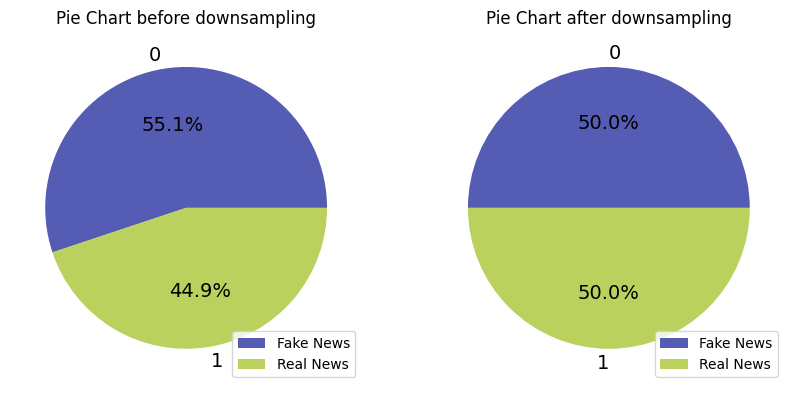

In [ ]:
counts_label = [df['label'].value_counts(), df_downsampled['label'].value_counts()]

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
for i, counts in enumerate(counts_label):
    ax[i].pie(counts, 
              labels=counts.index, 
              autopct='%1.1f%%', 
              colors=['#555CB3', '#BAD15E'], 
              textprops={'fontsize': 14})
    ax[i].set_title("Pie Chart " + ("before" if i == 0 else "after") + " downsampling")
    ax[i].legend(labels=['Fake News', 'Real News'], loc='lower right')

plt.show()

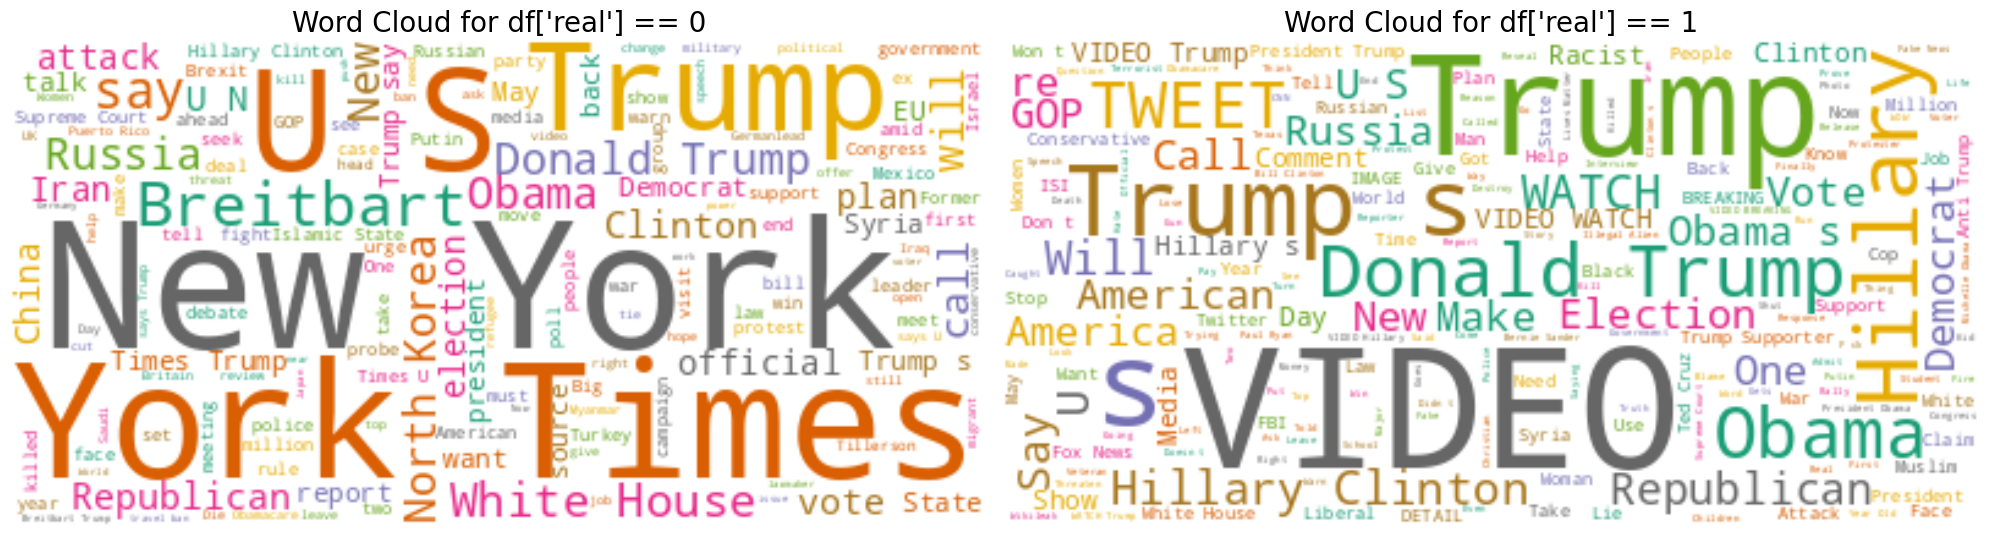

In [38]:
generate_word_cloud(dataset = df_downsampled, column1 = 'title')

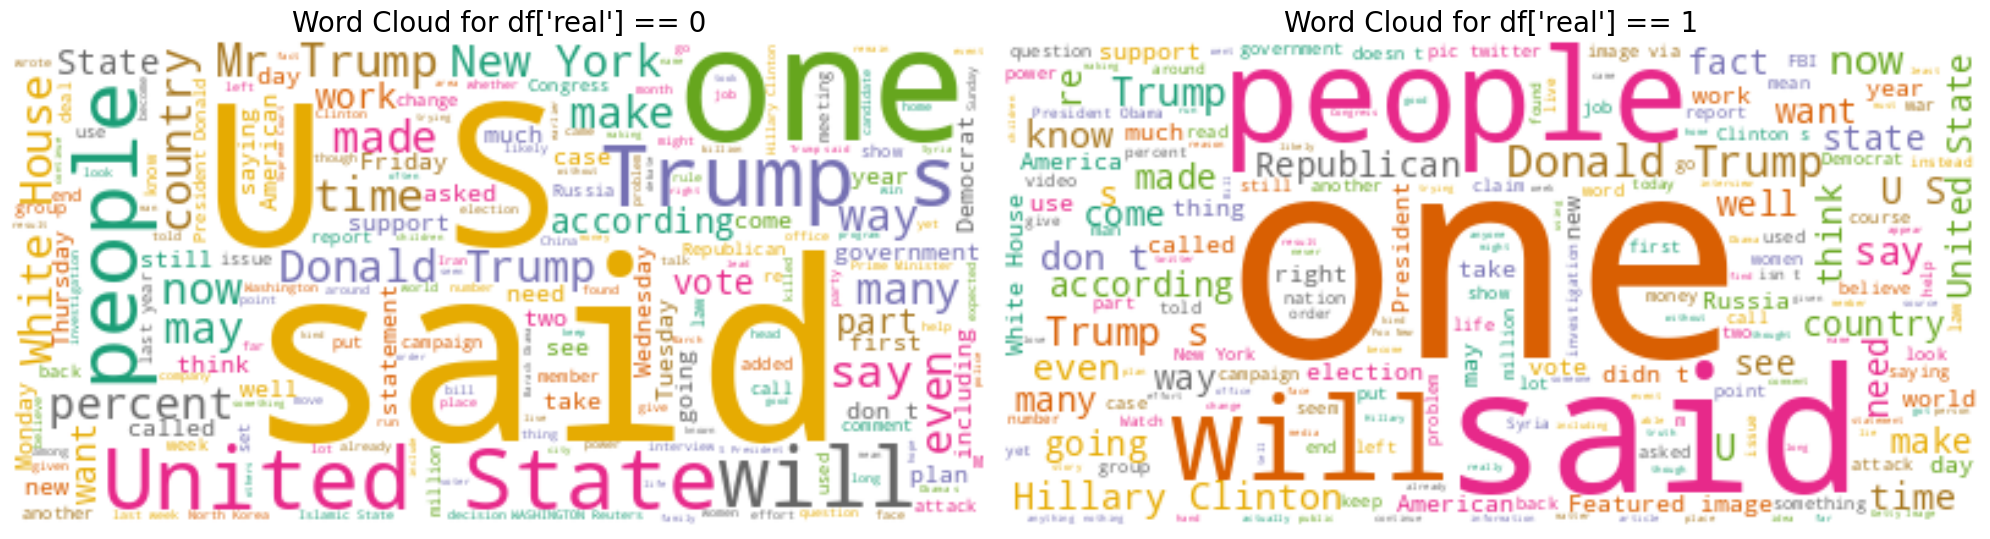

In [39]:
generate_word_cloud(dataset = df_downsampled, column1 = 'text')

## In chunks: stopwords, tokenizer, stemming

### without stopwords

In [ ]:
chunks = pd.read_csv('df_downsampled_welfake.csv', chunksize=10000)

In [ ]:
processed_chunks = []
for chunk in chunks:

    remove_stopwords_and_punctuation(chunk, columns=['title'])
    
    tokenize(chunk, 'title')

    stem_title = chunk['title'].apply(stem_tokens)

    processed_chunks.append(stem_title)

df_chunks_wo_stopwords_title = pd.concat(processed_chunks, axis=0)
df_chunks_wo_stopwords_title = pd.DataFrame(df_chunks_wo_stopwords_title)
df_chunks_wo_stopwords_title.head(3)

,title
0,"[bobbi, jindal, rais, hindu, use, stori, chris..."
1,"[may, brexit, offer, would, hurt, cost, eu, ci..."
2,"[schumer, call, trump, appoint, offici, overse..."


In [ ]:
chunks = pd.read_csv('df_downsampled_welfake.csv', chunksize=10000)

In [ ]:
processed_chunks = []
for chunk in chunks:

    remove_stopwords_and_punctuation(chunk, columns=['text'])
    
    tokenize(chunk, 'text')

    stem_text = chunk['text'].apply(stem_tokens)

    processed_chunks.append(stem_text)

df_chunks_wo_stopwords_text = pd.concat(processed_chunks, axis=0)
df_chunks_wo_stopwords_text = pd.DataFrame(df_chunks_wo_stopwords_text)
df_chunks_wo_stopwords_text.head(3)

,text
0,"[dozen, polit, activ, pastor, came, privat, di..."
1,"[brussel, reuter, british, prime, minist, ther..."
2,"[washington, reuter, charl, schumer, top, demo..."


### with stopwords

In [ ]:
chunks = pd.read_csv('df_downsampled_welfake.csv', chunksize=10000)

In [ ]:
processed_chunks = []
for chunk in chunks:
    
    tokenize(chunk, 'title')

    stem_title = chunk['title'].apply(stem_tokens)

    processed_chunks.append(stem_title)

df_chunks_stopwords_title = pd.concat(processed_chunks, axis=0)
df_chunks_stopwords_title = pd.DataFrame(df_chunks_stopwords_title)
df_chunks_stopwords_title.head(3)

,title
0,"[bobbi, jindal, ,, rais, hindu, ,, use, stori,..."
1,"[may, brexit, offer, would, hurt, ,, cost, eu,..."
2,"[schumer, call, on, trump, to, appoint, offici..."


In [ ]:
chunks = pd.read_csv('df_downsampled_welfake.csv', chunksize=10000)

In [ ]:
processed_chunks = []
for chunk in chunks:
    
    tokenize(chunk, 'text')

    stem_text = chunk['text'].apply(stem_tokens)

    processed_chunks.append(stem_text)

df_chunks_stopwords_text = pd.concat(processed_chunks, axis=0)
df_chunks_stopwords_text = pd.DataFrame(df_chunks_stopwords_text)
df_chunks_stopwords_text.head(3)

,text
0,"[a, dozen, polit, activ, pastor, came, here, f..."
1,"[brussel, (, reuter, ), -, british, prime, min..."
2,"[washington, (, reuter, ), -, charl, schumer, ..."


## Bag-of-words algorithm

In [ ]:
#without stopwords

df_bow_title = create_bow_df(df=df_chunks_wo_stopwords_title, col='title')
df_bow_text = create_bow_df(df=df_chunks_wo_stopwords_text, col='text')

In [ ]:
# with stopwords

df_bow_stopwords_title = create_bow_df(df=df_chunks_stopwords_title, col='title')
df_bow_stopwords_text = create_bow_df(df=df_chunks_stopwords_text, col='text')

## Bag2Vec

In [ ]:
#without stopwords

df_b2v_title = create_b2v_df(df=df_chunks_wo_stopwords_title, col='title')
df_b2v_text = create_b2v_df(df=df_chunks_wo_stopwords_text, col='text')

In [ ]:
# with stopwords

df_b2v_title_stopwords = create_b2v_df(df=df_chunks_stopwords_title, col='title')
df_b2v_text_stopwords = create_b2v_df(df=df_chunks_stopwords_text, col='text')

## Sentence Transformer

In [14]:
df_stopwords = df_downsampled.copy()

In [15]:
remove_stopwords_and_punctuation(df = df_stopwords , columns = ['title', 'text'])

In [22]:
df_st = df_stopwords.copy()

In [17]:
model = SentenceTransformer('distilbert-base-nli-mean-tokens')

In [24]:
title = model.encode(df_st['title'].values.tolist(), convert_to_tensor=True)
# text = model.encode(df_st['text'].values.tolist(), convert_to_tensor=True)

# Models - 1st root
*   cut stopwords: no
*   tokenize: yes
*   bag-of-words

In [ ]:
# extract X and y
X = pd.concat([df_bow_stopwords_title, df_bow_stopwords_text], axis=1).values
y = df_downsampled['label'].values

## Logistic Regression with Optuna

In [ ]:
(X_train, y_train), (X_val, y_val), (X_test, y_test) = split_data(X, y)

In [ ]:
create_logistic_regression(X_train, X_val, X_test, y_train, y_val, y_test)

[I 2023-04-29 12:21:35,812] A new study created in memory with name: no-name-13910fd7-f2d0-4fd7-8d2d-10d4a2af2716
/content/drive/MyDrive/Colab Notebooks/Codecool/Fake News Classification/modeling_scripts.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
[I 2023-04-29 12:23:30,811] Trial 0 finished with value: 0.9532477259635925 and parameters: {'lr': 1.2680182270483677e-05, 'batch_size': 16, 'epochs': 31}. Best is trial 0 with value: 0.9532477259635925.
[I 2023-04-29 12:24:04,038] Trial 1 finished with value: 0.9662770628929138 and parameters: {'lr': 0.00041151757130226333, 'batch_size': 32, 'epochs': 14}. Best is trial 1 with value: 0.9662770628929138.
[I 2023-04-29 12:25:05,203] Trial 2 finished with value: 0.9615826606750488 and parameters: {'lr': 7.667104846180

Best trial:
  Loss: 0.9682
  Params: 
    lr: 0.0009614843504245648
    batch_size: 32
    epochs: 42
Training set: loss=0.0000, accuracy=1.0000
Validation set: loss=8.4405, accuracy=0.9114
Test set: loss=8.6494, accuracy=0.9097


## Cross validation

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

In [ ]:
perform_kfold_cross_validation(X_train, y_train, X_test, y_test, n_splits=5, batch_size=16, learning_rate=1e-3, num_epochs=10)

Fold 1: Train accuracy = 0.6667, Validation accuracy = 0.9694
Fold 2: Train accuracy = 1.0000, Validation accuracy = 0.9642
Fold 3: Train accuracy = 1.0000, Validation accuracy = 0.9691
Fold 4: Train accuracy = 1.0000, Validation accuracy = 0.9661
Fold 5: Train accuracy = 1.0000, Validation accuracy = 0.9675
Test accuracy = 0.9670
Average train accuracy = 0.9333
Average validation accuracy = 0.9673


## More complex NN

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

In [ ]:
create_more_complex_nn(X_train, y_train, X_test, y_test, n_splits=5, batch_size=16, learning_rate=1e-3, num_epochs=10)

Fold 1: Train accuracy = 0.9937, Validation accuracy = 0.9735
Fold 2: Train accuracy = 0.9976, Validation accuracy = 0.9748
Fold 3: Train accuracy = 0.9941, Validation accuracy = 0.9710
Fold 4: Train accuracy = 0.9931, Validation accuracy = 0.9705
Fold 5: Train accuracy = 0.9968, Validation accuracy = 0.9766
Test accuracy = 0.9792
Average train accuracy = 0.9950
Average validation accuracy = 0.9733


# Models - 2nd root
*   cut stopwords: no
*   tokenize: yes
*   Bag2Vec

In [ ]:
# extract X and y
X = pd.concat([df_b2v_title_stopwords, df_b2v_text_stopwords], axis=1).values
y = df_downsampled['label'].values

## Logistic Regression with Optuna

In [ ]:
(X_train, y_train), (X_val, y_val), (X_test, y_test) = split_data(X, y)

In [ ]:
create_logistic_regression(X_train, X_val, X_test, y_train, y_val, y_test)

[I 2023-04-29 17:02:48,062] A new study created in memory with name: no-name-e07c2426-9547-4a77-891c-017e1d170e55
/content/drive/My Drive/Colab Notebooks/Codecool/Fake News Classification/modeling_scripts.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
[I 2023-04-29 17:03:11,026] Trial 0 finished with value: 0.8867599368095398 and parameters: {'lr': 0.0032142933833781456, 'batch_size': 32, 'epochs': 12}. Best is trial 0 with value: 0.8867599368095398.
[I 2023-04-29 17:04:54,898] Trial 1 finished with value: 0.9030465483665466 and parameters: {'lr': 0.0003916527773969781, 'batch_size': 16, 'epochs': 33}. Best is trial 1 with value: 0.9030465483665466.
[I 2023-04-29 17:05:44,112] Trial 2 finished with value: 0.9179919362068176 and parameters: {'lr': 0.0001624330893

Best trial:
  Loss: 0.9303
  Params: 
    lr: 0.000715358459262113
    batch_size: 16
    epochs: 28
Training set: loss=50.0000, accuracy=0.5000
Validation set: loss=50.6706, accuracy=0.4933
Test set: loss=50.0766, accuracy=0.4992


## Cross validation

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

In [ ]:
perform_kfold_cross_validation(X_train, y_train, X_test, y_test, n_splits=5, batch_size=16, learning_rate=1e-3, num_epochs=10)

Fold 1: Train accuracy = 1.0000, Validation accuracy = 0.9136
Fold 2: Train accuracy = 1.0000, Validation accuracy = 0.9187
Fold 3: Train accuracy = 1.0000, Validation accuracy = 0.8890
Fold 4: Train accuracy = 1.0000, Validation accuracy = 0.9176
Fold 5: Train accuracy = 1.0000, Validation accuracy = 0.9209
Test accuracy = 0.9117
Average train accuracy = 1.0000
Average validation accuracy = 0.9119


## More complex NN

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

In [ ]:
create_more_complex_nn(X_train, y_train, X_test, y_test, n_splits=5, batch_size=16, learning_rate=1e-3, num_epochs=10)

Fold 1: Train accuracy = 0.9524, Validation accuracy = 0.9489
Fold 2: Train accuracy = 0.9539, Validation accuracy = 0.9513
Fold 3: Train accuracy = 0.9436, Validation accuracy = 0.9398
Fold 4: Train accuracy = 0.9564, Validation accuracy = 0.9507
Fold 5: Train accuracy = 0.9332, Validation accuracy = 0.9330
Test accuracy = 0.9384
Average train accuracy = 0.9479
Average validation accuracy = 0.9448


# Models - 3rd root
*   cut stopwords: yes
*   tokenize: no
*   Sentence Transformer

In [26]:
X = title
y = df_st['label'].values

## Logistic Regression with Optuna

In [28]:
(X_train, y_train), (X_val, y_val), (X_test, y_test) = split_data(X, y)

In [29]:
create_logistic_regression(X_train, X_val, X_test, y_train, y_val, y_test)

[I 2023-05-02 20:28:04,389] A new study created in memory with name: no-name-a8293a1e-9080-4104-8f15-3479a751dcfe
/content/drive/My Drive/Colab Notebooks/Codecool/Fake News Classification/modeling_scripts.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
/content/drive/My Drive/Colab Notebooks/Codecool/Fake News Classification/modeling_scripts.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X, dtype=torch.float32)
[I 2023-05-02 20:28:29,100] Trial 0 finished with value: 0.851312518119812 and parameters: {'lr': 0.0006732374899951047, 'batch_size': 64, 'epochs': 32}. Best is trial 0 with val

Best trial:
  Loss: 0.8554
  Params: 
    lr: 0.00691484547692208
    batch_size: 64
    epochs: 40
Training set: loss=0.0000, accuracy=1.0000
Validation set: loss=23.2049, accuracy=0.7670
Test set: loss=23.1552, accuracy=0.7677


## Cross validation

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [34]:
perform_kfold_cross_validation(X_train,  y_train, X_test, y_test, n_splits=5, batch_size=16, learning_rate=1e-3, num_epochs=10)

/content/drive/My Drive/Colab Notebooks/Codecool/Fake News Classification/modeling_scripts.py:133: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X, dtype=torch.float32)


Fold 1: Train accuracy = 1.0000, Validation accuracy = 0.8528
Fold 2: Train accuracy = 0.7500, Validation accuracy = 0.8543
Fold 3: Train accuracy = 1.0000, Validation accuracy = 0.8576
Fold 4: Train accuracy = 1.0000, Validation accuracy = 0.8575
Fold 5: Train accuracy = 0.5000, Validation accuracy = 0.8466
Test accuracy = 0.8547
Average train accuracy = 0.8500
Average validation accuracy = 0.8538


## More complex NN

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [32]:
create_more_complex_nn(X_train, y_train, X_test, y_test, n_splits=5, batch_size=16, learning_rate=1e-3, num_epochs=10)

/content/drive/My Drive/Colab Notebooks/Codecool/Fake News Classification/modeling_scripts.py:222: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X, dtype=torch.float32)


Fold 1: Train accuracy = 0.8924, Validation accuracy = 0.8751
Fold 2: Train accuracy = 0.8921, Validation accuracy = 0.8679
Fold 3: Train accuracy = 0.8856, Validation accuracy = 0.8698
Fold 4: Train accuracy = 0.8764, Validation accuracy = 0.8608
Fold 5: Train accuracy = 0.9014, Validation accuracy = 0.8692
Test accuracy = 0.8751
Average train accuracy = 0.8896
Average validation accuracy = 0.8686


# Models - 4th root
*   cut stopwords: yes
*   tokenize: yes
*   convert to stem: yes
*   bag-of-words



In [ ]:
# extract X and y
X = pd.concat([df_bow_title, df_bow_text], axis=1).values
y = df_downsampled['label'].values

## Logistic Regression with Optuna

In [ ]:
(X_train, y_train), (X_val, y_val), (X_test, y_test) = split_data(X, y)

In [ ]:
create_logistic_regression(X_train, X_val, X_test, y_train, y_val, y_test)

[I 2023-04-29 11:49:38,542] A new study created in memory with name: no-name-72d39239-aca9-489c-b923-0a816c36f170
/content/drive/My Drive/Colab Notebooks/Codecool/Fake News Classification/modeling_scripts.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
[I 2023-04-29 11:50:27,704] Trial 0 finished with value: 0.9531519412994385 and parameters: {'lr': 0.002338517549208085, 'batch_size': 64, 'epochs': 36}. Best is trial 0 with value: 0.9531519412994385.
[I 2023-04-29 11:51:08,466] Trial 1 finished with value: 0.9505652189254761 and parameters: {'lr': 0.06783255748592623, 'batch_size': 32, 'epochs': 20}. Best is trial 0 with value: 0.9531519412994385.
[I 2023-04-29 11:51:41,939] Trial 2 finished with value: 0.955930233001709 and parameters: {'lr': 0.00040026519836998

Best trial:
  Loss: 0.9559
  Params: 
    lr: 0.00040026519836998045
    batch_size: 64
    epochs: 25
Training set: loss=42.9153, accuracy=0.5000
Validation set: loss=3.1066, accuracy=0.9196
Test set: loss=2.7654, accuracy=0.9254


## Cross validation

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
perform_kfold_cross_validation(X_train, y_train, X_test, y_test, n_splits=5, batch_size=16, learning_rate=1e-3, num_epochs=10)

Fold 1: Train accuracy = 1.0000, Validation accuracy = 0.9594
Fold 2: Train accuracy = 1.0000, Validation accuracy = 0.9573
Fold 3: Train accuracy = 1.0000, Validation accuracy = 0.9582
Fold 4: Train accuracy = 1.0000, Validation accuracy = 0.9590
Fold 5: Train accuracy = 1.0000, Validation accuracy = 0.9589
Test accuracy = 0.9603
Average train accuracy = 1.0000
Average validation accuracy = 0.9586


## More complex NN

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
create_more_complex_nn(X_train, y_train, X_test, y_test, n_splits=5, batch_size=16, learning_rate=1e-3, num_epochs=10)

Fold 1: Train accuracy = 0.9960, Validation accuracy = 0.9633
Fold 2: Train accuracy = 0.9969, Validation accuracy = 0.9688
Fold 3: Train accuracy = 0.9969, Validation accuracy = 0.9693
Fold 4: Train accuracy = 0.9977, Validation accuracy = 0.9676
Fold 5: Train accuracy = 0.9982, Validation accuracy = 0.9667
Test accuracy = 0.9685
Average train accuracy = 0.9972
Average validation accuracy = 0.9671


# Models - 5th root

*   cut stopwords: yes
*   tokenize: yes
*   convert to stem: yes
*   Bag2Vec

In [ ]:
X = pd.concat([df_b2v_title, df_b2v_text], axis=1).values
y = df_downsampled['label'].values

## Logistic Regression with Optuna

In [ ]:
(X_train, y_train), (X_val, y_val), (X_test, y_test) = split_data(X, y)

In [ ]:
create_logistic_regression(X_train, X_val, X_test, y_train, y_val, y_test)

[I 2023-04-29 15:38:08,972] A new study created in memory with name: no-name-1db8bc15-3b30-44f5-8de1-f9678452bb28
/content/drive/My Drive/Colab Notebooks/Codecool/Fake News Classification/modeling_scripts.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
[I 2023-04-29 15:38:22,456] Trial 0 finished with value: 0.8277447819709778 and parameters: {'lr': 0.01604128902361606, 'batch_size': 64, 'epochs': 11}. Best is trial 0 with value: 0.8277447819709778.
[I 2023-04-29 15:40:14,732] Trial 1 finished with value: 0.7852078676223755 and parameters: {'lr': 0.011951011897557732, 'batch_size': 16, 'epochs': 39}. Best is trial 0 with value: 0.8277447819709778.
[I 2023-04-29 15:41:16,350] Trial 2 finished with value: 0.8679823875427246 and parameters: {'lr': 0.0001748385336217

Best trial:
  Loss: 0.8776
  Params: 
    lr: 0.000262362681384924
    batch_size: 16
    epochs: 29
Training set: loss=0.0000, accuracy=1.0000
Validation set: loss=18.2624, accuracy=0.8171
Test set: loss=17.7335, accuracy=0.8223


## Cross validation

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
perform_kfold_cross_validation(X_train, y_train, X_test, y_test, n_splits=5, batch_size=16, learning_rate=1e-3, num_epochs=10)

Fold 1: Train accuracy = 1.0000, Validation accuracy = 0.8326
Fold 2: Train accuracy = 0.5000, Validation accuracy = 0.8648
Fold 3: Train accuracy = 1.0000, Validation accuracy = 0.8641
Fold 4: Train accuracy = 0.7500, Validation accuracy = 0.8455
Fold 5: Train accuracy = 0.7500, Validation accuracy = 0.8626
Test accuracy = 0.8783
Average train accuracy = 0.8000
Average validation accuracy = 0.8539


## More complex NN

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

In [ ]:
create_more_complex_nn(X_train, y_train, X_test, y_test, n_splits=5, batch_size=16, learning_rate=1e-3, num_epochs=10)

Fold 1: Train accuracy = 0.9133, Validation accuracy = 0.9097
Fold 2: Train accuracy = 0.9199, Validation accuracy = 0.9140
Fold 3: Train accuracy = 0.9209, Validation accuracy = 0.9084
Fold 4: Train accuracy = 0.9165, Validation accuracy = 0.9108
Fold 5: Train accuracy = 0.9210, Validation accuracy = 0.9176
Test accuracy = 0.9174
Average train accuracy = 0.9183
Average validation accuracy = 0.9121


# Similar news

In [16]:
df_similarnews = df.iloc[:10000]

In [17]:
# create the tf-idf vectorizer
vectorizer = TfidfVectorizer()

# fit the vectorizer on the news titles
tfidf_matrix = vectorizer.fit_transform(df_similarnews['title'])

# calculate cosine distance between all pairs of news titles
cosine_sim = 1 - cosine_distances(tfidf_matrix)

In [19]:
# the index of the first article
index = 0

# get the cosine distances of the first article to all other articles
distances = cosine_sim[index]

# sort the distances in descending order
sorted_distances = sorted(enumerate(distances), key=lambda x: x[1], reverse=True)

# print the selected article
print('Selected article:\n', df_similarnews.loc[index, 'title'], '\n')

# print the top 5 most similar articles
for i, distance in sorted_distances[1:6]:
    print(df_similarnews.loc[i, 'title'])


Selected article:
 LAW ENFORCEMENT ON HIGH ALERT Following Threats Against Cops And Whites On 9-11By #BlackLivesMatter And #FYF911 Terrorists [VIDEO] 

Poll: Hillary Clinton tops Donald Trump, GOP field on handling terror
Dutch Men Hold Hands in Solidarity With Attacked Gay Couple - The New York Times
If they could, most Democrats would reelect Obama over Clinton
LIBERAL FED JUDGE Who Sided With BLACK LIVES MATTER Terror Group Over Seattle Cops STOPS Trump’s Immigration Travel Ban [VIDEO]
Monmouth poll: 6-point Clinton lead over Trump day before U.S. election
